In [145]:
import pandas as pd
import pydeck as pdk
import networkx as nx
import matplotlib.pyplot as plt
from utils.cflp_function import *
from utils.calculate_od import *
from pysal.lib import weights
from pysal.explore import esda

**pd.read.csv** reads a CSV file and returns a DataFrame. In this case, it’s loading hexagonal data.

In [146]:
# Load hex data
hex = pd.read_csv('./hex/hex_df2.csv')

**pdk.Layer** creates a layer for a map visualization. Here, it’s creating a layer of hexagons with various properties.

**pdk.Deck** creates a map visualization with the specified layers. Here, it’s creating a map with the hexagon layer.

**.to_html** saves the map visualization to an HTML file. Here, it’s saving the map as “layer.html”.

In [147]:
# Define a layer to display on a map
layer = pdk.Layer(
    "H3HexagonLayer",
    hex,
    pickable=True,
    filled=True,
    extruded=False,
    auto_highlight=True,
    opacity=0.6,
    get_hexagon="hex9",
    get_fill_color = 'color', 
    get_line_color=[255, 255, 255],
    line_width_min_pixels=0.1
)

# Set the viewport location
view_state = pdk.ViewState(longitude=4.390, latitude=51.891, zoom=6, bearing=0, pitch=0)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "Value: {fuzzy}"})
r.to_html("layer.html")

**gpd.read_file** reads a shapefile and returns a GeoDataFrame. Here, it’s loading H3 polygon data.

In [148]:
# Load H3 polygons
idx = gpd.read_file('app_data/h3_polygons.shp')
idx = idx.set_index('hex9')

### Spatial Autocorrelation

**weights.Queen.from_dataframe** creates a spatial weights matrix based on the Queen contiguity criterion. Here, it’s creating a weights matrix from the H3 polygons.

In [149]:
# Compute spatial weights
w = weights.Queen.from_dataframe(idx, use_index=True)
w.transform = 'R'  # Row standardize the matrix

('WARNING: ', '891f16c693bffff', ' is an island (no neighbors)')
('WARNING: ', '891f1610e8fffff', ' is an island (no neighbors)')


/home/vscode/.local/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 2 islands with ids: 891f16c693bffff, 891f1610e8fffff.
  W.__init__(self, neighbors, ids=ids, **kw)


**idx.merge** merges two DataFrames based on a common column. Here, it’s merging the H3 polygons with the hexagonal data based on the ‘hex9’ column.

In [150]:
# Merge compound suitability map and H3 geometry information
hex_df = idx.merge(hex[['hex9','color','fuzzy']], on='hex9',how='left')

In [151]:
# Standardize fuzzy values
hex_df['fuzzy_std'] = (hex_df['fuzzy'] - hex_df['fuzzy'].mean()) / hex_df['fuzzy'].std()
hex_df['lag_std'] = weights.lag_spatial(w, hex_df['fuzzy_std'])
hex_df['lag'] = weights.lag_spatial(w, hex_df['fuzzy'])

**esda.Moran_Local** calculates local Moran’s I, a measure of spatial autocorrelation. Here, it’s calculating local Moran’s I for the ‘fuzzy’ values.

In [152]:
# Compute local Moran's I
lisa = esda.Moran_Local(hex_df['fuzzy'], w, seed=42)

In [153]:
# Identify significant observations
significant = lisa.p_sim < 0.05
quadrant = lisa.q
significant_001 = lisa.p_sim < 0.01


**w.to_networkx** converts the weights matrix to a NetworkX graph. Here, it’s creating a graph from the weights matrix.

In [154]:
# Transform weight back to Binary
w.transform = 'B'
g = w.to_networkx()

**nx.relabel_nodes** relabels the nodes of a graph. Here, it’s relabeling the nodes of the graph with H3 indices.

In [155]:
# Relabel nodes with H3 index
mapping = {new_index: old_index for new_index, old_index in enumerate(w.id_order)}
g = nx.relabel_nodes(g, mapping)

In [156]:
# Get indices of H3 cells that are in the HH quadrant (p-value < 0.01)
hh = hex_df[(significant_001 == True) & (quadrant == 1)].hex9.to_list()

**g.subgraph** creates a subgraph from a graph. Here, it’s creating a subgraph that includes only the HH quadrant.

In [157]:
# Get sub graph that includes only the HH quadrant
h = g.subgraph(hh)

**list** finds the connected components of a graph. Here, it’s finding the connected components of the subgraph.

In [158]:
# Get connected components in the sub graphs
subh = list(nx.connected_components(h))

nx.eigenvector_centrality(subgraph, max_iter=1000): This function calculates the eigenvector centrality of a graph. Here, it’s calculating the eigenvector centrality for each connected component of the subgraph.
gc.collect(): This function triggers garbage collection, which can help free up memory.
sns.histplot(...): This function creates a histogram. Here, it’s creating histograms of the eigenvector centrality and the ‘fuzzy’ values.
sns.regplot(x=hex_df['fuzzy'], y=hex_df['lag']): This function creates a scatter plot with a regression line. Here, it’s creating a scatter plot of the spatial lag vs the ‘fuzzy’ values.

In [159]:
# Filter connected components
filter_subh = [component for component in subh if len(component) > 10]

In [160]:
# Calculate eigenvector centrality for each connected component
eigenvector_centralities = []
for component in filter_subh:
    # Create a subgraph for the current connected component
    subgraph = h.subgraph(component)
    
    # Calculate eigenvector centrality for the subgraph
    eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=1000)
    
    # Append the result to the list
    eigenvector_centralities.append(eigenvector_centrality)

In [161]:
# Identify sites
site = []
for centrality_dict in eigenvector_centralities:
    max_node_index = max(centrality_dict, key=centrality_dict.get)
    site.append(max_node_index)

In [162]:
# Clean up memory
import gc
gc.collect()

11634

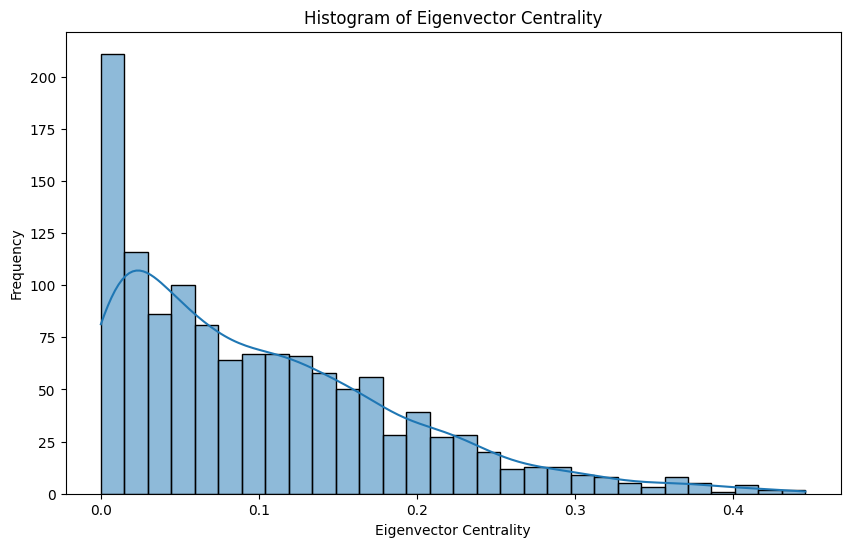

In [163]:
# Visualize the Eigenvector Centrality with KDE
plt.figure(figsize=(10, 6))
sns.histplot([centrality for subgraph in eigenvector_centralities for centrality in subgraph.values()], bins=30, kde=True)
plt.title('Histogram of Eigenvector Centrality')
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.show()

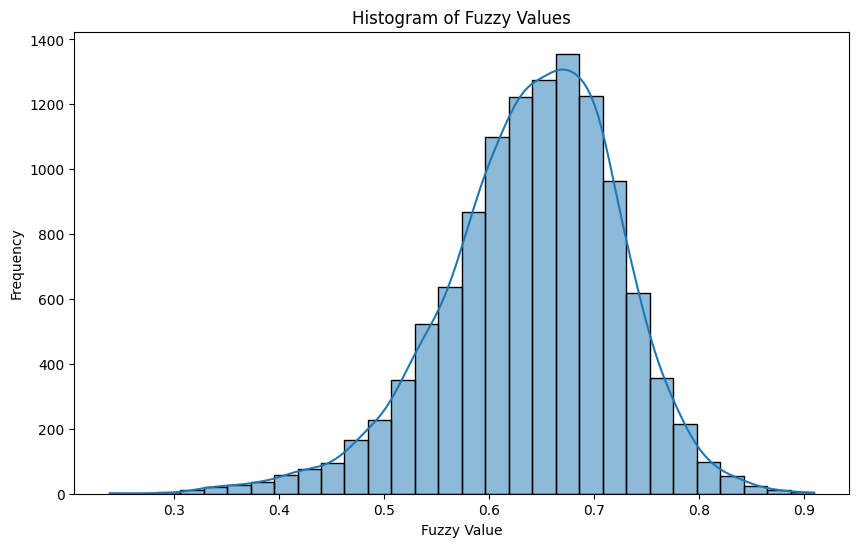

In [164]:
# Histogram of Fuzzy Values with KDE
plt.figure(figsize=(10, 6))
sns.histplot(hex_df['fuzzy'].dropna(), bins=30, kde=True)
plt.title('Histogram of Fuzzy Values')
plt.xlabel('Fuzzy Value')
plt.ylabel('Frequency')
plt.show()

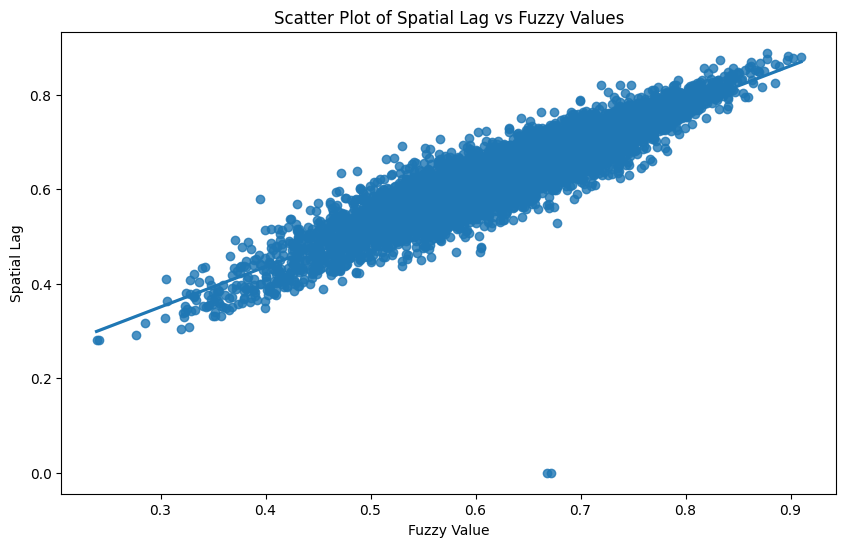

In [165]:
# Scatter Plot of Spatial Lag vs Fuzzy Values with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=hex_df['fuzzy'], y=hex_df['lag'])
plt.title('Scatter Plot of Spatial Lag vs Fuzzy Values')
plt.xlabel('Fuzzy Value')
plt.ylabel('Spatial Lag')
plt.show()